In [26]:
require(codyn)
require(reshape2)
require(dplyr)
require(ggplot2)

Loading required package: ggplot2


In [2]:
trees_df = read.csv("../Results/trees_matrix.csv", row.names=1)
mamls_df = read.csv("../Results/m_trap-year.csv", row.names=1)
btles_df = read.csv("../Results/btles_matrix.csv", row.names=1)

In [3]:
add_cols = function(df){
    df$plot    = unlist(strsplit(rownames(df), "_"))[ c(T,F,F)]
    df$subplot = unlist(strsplit(rownames(df), "_"))[ c(F,T,F)]
    df$census  = unlist(strsplit(rownames(df), "_"))[ c(F,F,T)]
    
    return(df)
    }


In [4]:
trees_df = add_cols(trees_df)
mamls_df = add_cols(mamls_df)
btles_df = add_cols(btles_df)

In [5]:
trees = melt(trees_df, id.vars=c("plot", "subplot", "census"))
mamls = melt(mamls_df, id.vars=c("plot", "subplot", "census"))
btles = melt(btles_df, id.vars=c("plot", "subplot", "census"))

In [6]:
spatial_stability = function(df){

    plts = unique(df$plot)

    for(plt in plts){
        a = subset(df, plot == plt)
        a$subplot = as.numeric(as.factor(a$subplot))

        if(exists('b')){
            b = rbind(b, a)
        } else{ b = a}
    }

    df = b

    df$census = paste0(df$plot, "_", df$census)

    stability = community_stability(df, 
                                    time.var = "subplot", 
                                    abundance.var = "value", 
                                    replicate.var = "census")

    return(stability)
    }

In [18]:
trees_stb = spatial_stability(trees)
mamls_stb = spatial_stability(mamls)
btles_stb = spatial_stability(btles)

In [19]:
trees_stb$taxa = "trees"
mamls_stb$taxa = "mammals"
btles_stb$taxa = "beetles"

In [20]:
trees_stb$plot = unlist(strsplit(trees_stb$census, "_"))[ c(T,F)]
mamls_stb$plot = unlist(strsplit(mamls_stb$census, "_"))[ c(T,F)]
btles_stb$plot = unlist(strsplit(btles_stb$census, "_"))[ c(T,F)]

In [23]:
trees_agb = read.csv("../Results/trees_agb.csv")
btles_agb = read.csv("../Results/btles_agb.csv")
mamls_agb = read.csv("../Results/mamls_agb.csv")

colnames(trees_agb) = c("plot", "agb")
colnames(mamls_agb) = c("plot", "agb")
colnames(btles_agb) = c("plot", "agb")

trees_stb = merge(trees_stb, trees_agb, by = "plot")
mamls_stb = merge(mamls_stb, mamls_agb, by = "plot")
btles_stb = merge(btles_stb, btles_agb, by = "plot")

In [ ]:
test = rbind(trees_stb, btles_stb, mamls_stb)
test = test[complete.cases(test), ]
test$taxa = as.factor(test$taxa)

test$agb = test$agb*16
test$logagb = log(test$agb)

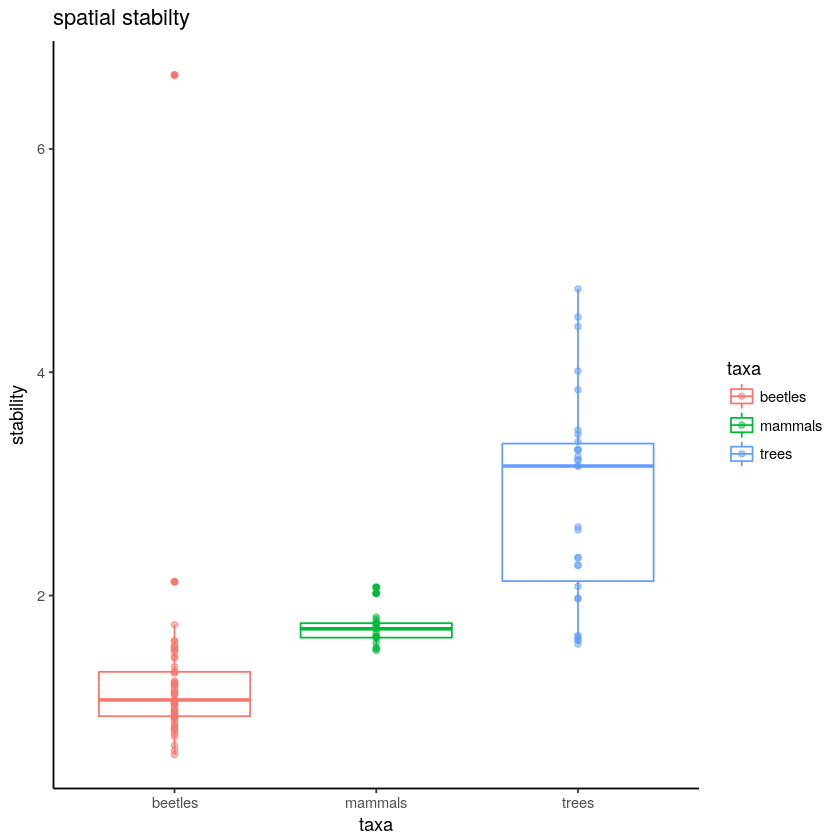

In [34]:
plt = ggplot(data = test, aes(x = taxa, y = stability, color = taxa))
plt = plt + geom_boxplot()
plt = plt + geom_point(alpha = 0.5)
plt = plt + theme_classic()
plt = plt + ggtitle("spatial stabilty")
print(plt)

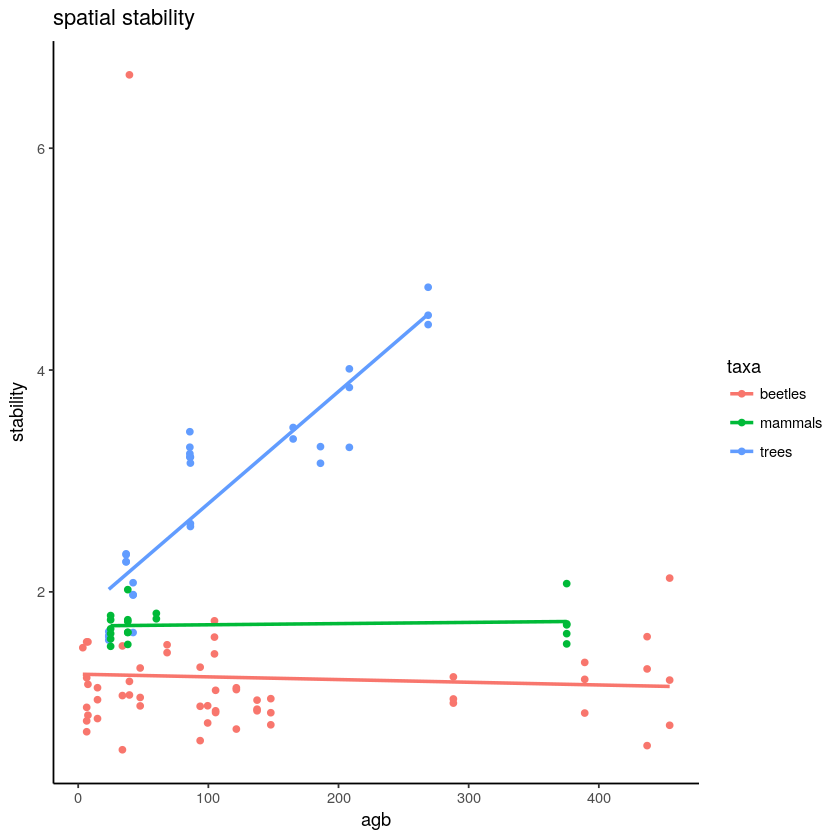

In [30]:
plt = ggplot(data = test, aes(x = agb, y = stability, color = taxa))
plt = plt + geom_point() 
plt = plt + geom_smooth(method = 'lm', se = F)
plt = plt + theme_classic()
plt = plt + ggtitle("spatial stability")
print(plt)

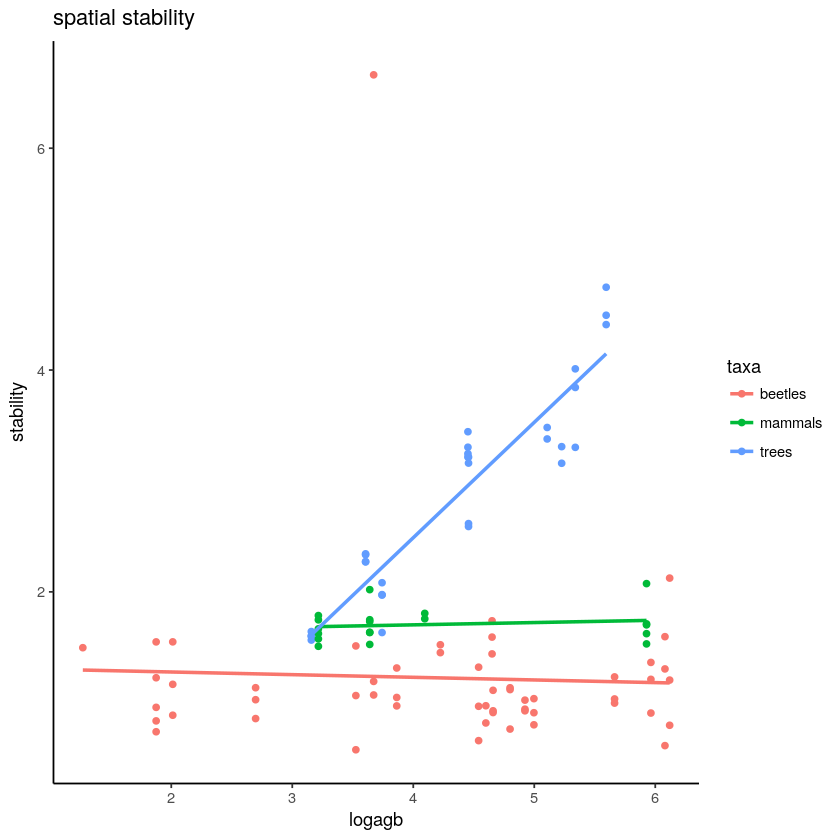

In [31]:
test = rbind(trees_stb, btles_stb, mamls_stb)
test = test[complete.cases(test), ]
test$taxa = as.factor(test$taxa)

test$agb = test$agb*16
test$logagb = log(test$agb)

plt = ggplot(data = test, aes(x = logagb, y = stability, color = taxa))
plt = plt + geom_point() 
plt = plt + geom_smooth(method = 'lm', se = F)
plt = plt + theme_classic()
plt = plt + ggtitle("spatial stability")
print(plt)